In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import random
from matplotlib import pyplot as plt
from collections import Counter,OrderedDict
# Setting random seeds to replicate results easily
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = "/content/drive/MyDrive/Colab Notebooks/comp4332/Project3/data"
# !rm -f data
# !ln -s "/content/drive/MyDrive/Colab Notebooks/comp4332/Project3/data" data

# Root Mean Squared Error (RMSE)

In [ ]:
def rmse(pred, actual):
    '''
    params:
        pred <np.array>: an array containing all predicted ratings
        actual <np.array>: an array containing all ground truth ratings

    return:
        a scalar whose value is the rmse
    '''
    # Ignore ratings with value zero.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

# Neural Collaborative Filtering (NCF) Model Implementation


In [ ]:
def build_ncf_model(n_users, n_items, embed_size, output_layer='dot', hidden_units:list = [128,64], dropout_rate = 0.15):
    '''
    params:
        n_users <int>: The number of user embedding vectors
        n_items <int>: The number of item embedding vectors
        embed_size <int>: The dimension of each embedding vector
        output_layer <str>: Indicates the instantiation of NCF to use, available options are either 'dot' or 'mlp'

    return:
        a keras Model object for the constructed ncf model
    '''
    # Get the users and items input
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')


    # Get the embeddings of users and items
    user_emb = Embedding(output_dim=embed_size, input_dim=n_users, input_length=1)(user_input)
    user_emb = Reshape((embed_size,))(user_emb)
    item_emb = Embedding(output_dim=embed_size, input_dim=n_items, input_length=1)(item_input)
    item_emb = Reshape((embed_size,))(item_emb)


    if output_layer == 'dot':
        # Compute the dot product of users' and items' embeddings as the model output
        model_output = Dot(axes=1)([user_emb, item_emb])

    elif output_layer == 'mlp':
        # Concatenate the users' and items' embeddings as the input of MLP
        mlp_input = Concatenate()([user_emb, item_emb])

        # First fully-connected layer
        # dense_1 = Dense(128, activation='relu')(mlp_input)
        # dense_1_dp = Dropout(0.15)(dense_1)

        # Second fully-connected layer
        # dense_2 = Dense(64, activation='relu')(dense_1_dp)
        # dense_2_dp = Dropout(0.15)(dense_2)
        input = mlp_input
        for hidden_unit in hidden_units:
          input = Dense(hidden_unit, activation='relu')(input)
          input = Dropout(dropout_rate)(input)
        model_output = Dense(1)(input)
    else:
        raise NotImplementedError

    model = Model(inputs=[user_input, item_input], outputs=model_output)
    return model

# Ratings Prediction

### Loading training and validation rating table

In [ ]:
tr_df = pd.read_csv("data/review.csv")
val_df = pd.read_csv("data/validation.csv")
test_df = pd.read_csv("data/prediction.csv")

### Building two dictionaries to map original user ids and item ids into corresponding indices in respective embedding matrices

In [ ]:
# Get the unique set of all user ids and set of all business ids in train set
user_set = set(tr_df.ReviewerID.unique())
business_set = set(tr_df.ProductID.unique())

# Build user vocabulary
user_vocab = dict(zip(user_set, range(1, len(user_set) + 1)))

# Reserve the first row of the embedding matrix for users unseen in the training set
user_vocab['unk'] = 0
n_users = len(user_vocab)

# Build business vocabulary
business_vocab = dict(zip(business_set, range(1, len(business_set) + 1)))
# Reserve the first row of the embedding matrix for businesses unseen in the training set
business_vocab['unk'] = 0
n_items = len(business_vocab)

### Replacing the original user and item ids in train and valdiation set with indices in embedding matrices

In [ ]:
# Transforming user_id into a number by the user_vocab dictionary, and
# transforming business_id into a number by the business_vocab dictonary
tr_users = tr_df.ReviewerID.apply(lambda x: user_vocab[x]).values
tr_items = tr_df.ProductID.apply(lambda x: business_vocab[x]).values
val_users = val_df.ReviewerID.apply(lambda x: user_vocab[x] if x in user_vocab else 0).values
val_items = val_df.ProductID.apply(lambda x: business_vocab[x] if x in business_vocab else 0).values

In [ ]:
te_users = test_df.ReviewerID.apply(lambda x: user_vocab[x] if x in user_vocab else 0).values
te_items = test_df.ProductID.apply(lambda x: business_vocab[x] if x in business_vocab else 0).values

### Retrieving ratings in the training and validation set

In [ ]:
tr_ratings = tr_df.Star.values
val_ratings = val_df.Star.values

In [ ]:
te_ratings = test_df.Star.values

### Oversampling implementation (did not improve the result)

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [ ]:
originalFeatures = pd.DataFrame({"ReviewerID":tr_users, "ProductID":tr_items})
oversampledFeatures, oversampled_ratings = smote.fit_resample(originalFeatures, tr_ratings)
oversampled_users = oversampledFeatures.ReviewerID.values
oversampled_items = oversampledFeatures.ProductID.values

### Undersampling implementation (did not improve the result)

In [ ]:
#undersampling
from sklearn.utils.class_weight import compute_class_weight
test_tr_ratings = tr_ratings - 1
test_val_ratings = val_ratings - 1
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(test_tr_ratings),
                                        y = test_tr_ratings
                                    )
class_weights = dict(zip(np.unique(test_tr_ratings), class_weights))
print(class_weights)

{0.0: 9.101381692573403, 1.0: 6.025957690108633, 2.0: 1.8806923625981442, 3.0: 0.6844210663030067, 4.0: 0.36611664987668047}


### Evaluation on the Effectiveness of oversampling, undersampling techniques

In [ ]:
model = build_ncf_model(n_users, n_items, embed_size=10, output_layer='mlp')
model.compile(optimizer='adam', loss='mse')
history = model.fit(
        [tr_users, tr_items],
        tr_ratings,
        validation_data = [[val_users,val_items],val_ratings],
        epochs=1,
        verbose=2,
        callbacks=[ModelCheckpoint('models/model.h5',monitor="loss",save_best_only=True)])
y_pred = model.predict([val_users, val_items])
print("Validation set RMSE: ", rmse(y_pred, val_ratings))

1647/1647 - 4s - loss: 1.2144 - val_loss: 0.7218 - 4s/epoch - 2ms/step
207/207 [==============================] - 0s 580us/step
Validation set RMSE:  0.8495767371621585


In [ ]:
#oversampling
model = build_ncf_model(n_users, n_items, embed_size=10, output_layer='mlp')
model.compile(optimizer='adam', loss='mse')
history = model.fit(
        # [tr_users, tr_items],
        # tr_ratings,
        [oversampled_users,oversampled_items],
        oversampled_ratings,
        validation_data = [[val_users,val_items],val_ratings],
        epochs=1,
        verbose=2,
        callbacks=[ModelCheckpoint('models/model.h5',monitor="loss",save_best_only=True)])
y_pred = model.predict([val_users, val_items])
print("Validation set RMSE: ", rmse(y_pred, val_ratings))

4498/4498 - 9s - loss: 1.8682 - val_loss: 2.0838 - 9s/epoch - 2ms/step
207/207 [==============================] - 0s 568us/step
Validation set RMSE:  1.4435256173829143


In [ ]:
#undersampling
model = build_ncf_model(n_users, n_items, embed_size=10, output_layer='mlp')
model.compile(optimizer='adam', loss='mse')
history = model.fit(
        [tr_users, tr_items],
        test_tr_ratings,
        validation_data = [[val_users,val_items],test_val_ratings],
        epochs=1,
        verbose=2,
        class_weight = class_weights,
        callbacks=[ModelCheckpoint('models/model.h5',monitor="loss",save_best_only=True)])
y_pred = model.predict([val_users, val_items])
print("Validation set RMSE: ", rmse(y_pred, test_val_ratings))

1647/1647 - 4s - loss: 1.4709 - val_loss: 1.9023 - 4s/epoch - 2ms/step
207/207 [==============================] - 0s 591us/step
Validation set RMSE:  1.3801597369863858


#Grid Search
look for optimal params for the CF-based recommendation

In [ ]:
model_params_and_validationloss = dict()

In [ ]:
import itertools
dims = [8,16,32,64,128,256]
#dims = [32]
#hidden_layers = [(128,64)]
hidden_units = [512,256,128,64,32,16]
hidden_layers = []
for r in range(1, 4): # limit the maximum number of layers to 3
    hidden_layers.extend(itertools.combinations(hidden_units, r))
hidden_layers = [
    perm for perm in hidden_layers if all(perm[i] > perm[i+1] for i in range(len(perm)-1))
]
#dropouts = [0.15]
dropouts = np.arange(0,1,0.2) #exclude 1

In [ ]:
#from the above graph, we can see that even a simple model will overfit after 2 epochs, hence, we limit the epoch to 2 during training
for dim in dims:
  for dropout in dropouts:
    for hidden_layer in hidden_layers:
      print("dim: ",dim," hidden layer: ",hidden_layer," dropout: ",dropout)
      model = build_ncf_model(n_users, n_items, embed_size=dim, output_layer='mlp',hidden_units=hidden_layer, dropout_rate=dropout)
      model.compile(optimizer='adam', loss='mse')
      history = model.fit(
              [tr_users, tr_items],
              tr_ratings,
              validation_data = [[val_users,val_items],val_ratings],
              epochs=1,
              verbose=1,
              callbacks=[ModelCheckpoint('Models/model-'+str(dim)+'-'+str(hidden_layer)+'-'+str(dropout)+'.h5',monitor="loss",save_best_only=True)])
      y_pred = model.predict([val_users, val_items])
      print("Validation set RMSE: ", rmse(y_pred, val_ratings))
      model_params_and_validationloss[(dim, hidden_layer, dropout)] = rmse(y_pred, val_ratings)


dim:  8  hidden layer:  (512,)  dropout:  0.0
207/207 [==============================] - 0s 552us/step
Validation set RMSE:  0.8466164742947383
dim:  8  hidden layer:  (256,)  dropout:  0.0
207/207 [==============================] - 0s 565us/step
Validation set RMSE:  0.8529344877492464
dim:  8  hidden layer:  (128,)  dropout:  0.0
207/207 [==============================] - 0s 564us/step
Validation set RMSE:  0.8500653550402409
dim:  8  hidden layer:  (64,)  dropout:  0.0
207/207 [==============================] - 0s 558us/step
Validation set RMSE:  0.8702974776345906
dim:  8  hidden layer:  (32,)  dropout:  0.0
207/207 [==============================] - 0s 566us/step
Validation set RMSE:  0.862472524345251
dim:  8  hidden layer:  (16,)  dropout:  0.0
207/207 [==============================] - 0s 572us/step
Validation set RMSE:  0.9084073613396413
dim:  8  hidden layer:  (512, 256)  dropout:  0.0
207/207 [==============================] - 0s 702us/step
Validation set RMSE:  0.852604726

In [ ]:
best_val_rmse = min(model_params_and_validationloss.values())
min_key = [key for key, value in model_params_and_validationloss.items() if value == best_val_rmse]
print("best validation loss: ",best_val_rmse, "model params: ",min_key[0])

best validation loss:  0.8421806456970286 model params:  (16, (128, 64), 0.0)


### Visualisation on model training result and further finetuning the parameters

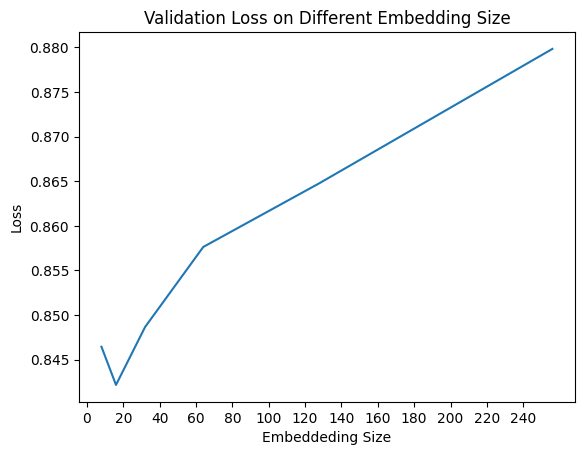

In [ ]:
dim, hidden_layer, dropout = min_key[0]
val_loss = [model_params_and_validationloss[(d,hidden_layer,dropout)] for d in dims]
min(val_loss)
#print(val_loss)
plt.plot(dims, val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Embeddeding Size')
plt.ylabel('Loss')
plt.title('Validation Loss on Different Embedding Size')
plt.xticks(np.arange(0,max(dims),20))

# Display the graph
plt.show()

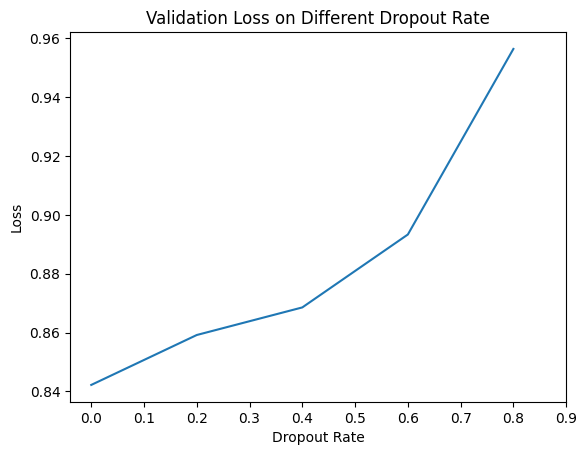

In [ ]:
dim, hidden_layer, dropout = min_key[0]
val_loss = [model_params_and_validationloss[(dim,hidden_layer,d)] for d in dropouts]
plt.plot(dropouts, val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Dropout Rate')
plt.ylabel('Loss')
plt.title('Validation Loss on Different Dropout Rate')
plt.xticks(np.arange(0,1,0.1))

# Display the graph
plt.show()

###further finetuning on dropout rate

In [ ]:
dropout_valLoss = dict()
dim, hidden_layer, _ = min_key[0]
dropouts = np.arange(0,1,0.1) #exclude 1
for dropout in dropouts:
        model = build_ncf_model(n_users, n_items, embed_size=dim, output_layer='mlp',hidden_units=hidden_layer, dropout_rate=dropout)
        model.compile(optimizer='adam', loss='mse')
        bestmodelhistory = model.fit(
                [tr_users, tr_items],
                tr_ratings,
                validation_data = [[val_users,val_items],val_ratings],
                epochs=1,
                verbose=1,
                callbacks=[ModelCheckpoint('bestmodel.h5',monitor="val_loss",save_best_only=True)])
        y_pred = model.predict([val_users, val_items])
        print("Validation set RMSE: ", rmse(y_pred, val_ratings))
        dropout_valLoss[(dim, hidden_layer, dropout)] = rmse(y_pred, val_ratings)

207/207 [==============================] - 0s 595us/step
Validation set RMSE:  0.8535486809915049
207/207 [==============================] - 0s 580us/step
Validation set RMSE:  0.8511009952494945
207/207 [==============================] - 0s 552us/step
Validation set RMSE:  0.8543459422958185
207/207 [==============================] - 0s 575us/step
Validation set RMSE:  0.8573395662733458
207/207 [==============================] - 0s 802us/step
Validation set RMSE:  0.8752860790990411
207/207 [==============================] - 0s 562us/step
Validation set RMSE:  0.8883640922166028
207/207 [==============================] - 0s 586us/step
Validation set RMSE:  0.891107218892818
207/207 [==============================] - 0s 573us/step
Validation set RMSE:  0.9410889074517073
207/207 [==============================] - 0s 569us/step
Validation set RMSE:  0.9460322476692998
207/207 [==============================] - 0s 558us/step
Validation set RMSE:  1.1198657917521944


In [ ]:
best_val_rmse = min(dropout_valLoss.values())
min_key[0] = [key for key, value in dropout_valLoss.items() if value == best_val_rmse]
print("best validation loss: ",best_val_rmse, "model params: ",min_key[0])

best validation loss:  0.8511009952494945 model params:  [(16, (128, 64), 0.1)]


###further finetuning on number of training epoch

In [ ]:
dim, hidden_layer, dropout = min_key[0][0]
model = build_ncf_model(n_users, n_items, embed_size=dim, output_layer='mlp',hidden_units=hidden_layer, dropout_rate=dropout)
model.compile(optimizer='adam', loss='mse')
bestmodelhistory = model.fit(
        [tr_users, tr_items],
        tr_ratings,
        validation_data = [[val_users,val_items],val_ratings],
        epochs=10,
        verbose=1,
        callbacks=[ModelCheckpoint('bestmodel.h5',monitor="val_loss",save_best_only=True)])


Epoch 1/10
1647/1647 [==============================] - 4s 2ms/step - loss: 1.1464 - val_loss: 0.7189
Epoch 2/10
1647/1647 [==============================] - 4s 2ms/step - loss: 0.5926 - val_loss: 0.7083
Epoch 3/10
1647/1647 [==============================] - 4s 2ms/step - loss: 0.5363 - val_loss: 0.7584
Epoch 4/10
1647/1647 [==============================] - 4s 2ms/step - loss: 0.4898 - val_loss: 0.7401
Epoch 5/10
1647/1647 [==============================] - 4s 2ms/step - loss: 0.4486 - val_loss: 0.7737
Epoch 6/10
1647/1647 [==============================] - 4s 2ms/step - loss: 0.4128 - val_loss: 0.8140
Epoch 7/10
1647/1647 [==============================] - 4s 2ms/step - loss: 0.3774 - val_loss: 0.8264
Epoch 8/10
1647/1647 [==============================] - 4s 2ms/step - loss: 0.3450 - val_loss: 0.8368
Epoch 9/10
1647/1647 [==============================] - 4s 2ms/step - loss: 0.3072 - val_loss: 0.8551
Epoch 10/10
1647/1647 [==============================] - 4s 2ms/step - loss: 0.273

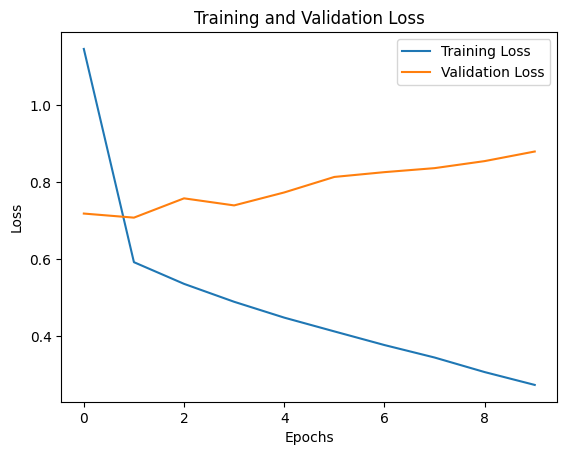

In [ ]:
# Access the loss values from the history object
train_loss = bestmodelhistory.history['loss']
val_loss = bestmodelhistory.history['val_loss']
# Plot the training and validation loss
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Add legend
plt.legend()

# Display the graph
plt.show()

###Model Loading and Predicting

In [ ]:
#dim, hidden_layer, dropout = min_key[0][0]
model = tf.keras.models.load_model('bestmodel.h5')#model name has to be changed later, after obtaining the best model
y_pred = model.predict([val_users, val_items])
print("Validation set RMSE: ", rmse(y_pred, val_ratings))
y_pred = model.predict([te_users, te_items])
test_df["Star"] = np.round(y_pred).astype(int)
#save the prediction
test_df.to_csv("prediction.csv", index=False)

207/207 [==============================] - 0s 572us/step
Validation set RMSE:  0.8415865899597444
207/207 [==============================] - 0s 559us/step
